<a href="https://colab.research.google.com/github/GeorgeM2000/Sports-Activity/blob/main/Sports_Activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!pip install pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

# Data Preprocessing

In [2]:
# Read excel file data
sport_data = pd.read_excel('Results_Saferun_2023_04_26_2_submit_With_Page.xlsx')

# Store it as csv file
sport_data.to_csv('Results_Saferun_2023_04_26_2_submit_With_Page.csv', index=False)

# Read csv file data
sport_data = pd.DataFrame(pd.read_csv('Results_Saferun_2023_04_26_2_submit_With_Page.csv'))

In [ ]:
sport_data.head()

,Weight,Height,Gender,Age,Running experience (years),"1) Do you feel any musculoskeletal discomfort (e.g pain, tightness, heaviness) related to your running activity?",2) Είδος πόνου,"IF YES, in which area of the body do you feel the symptom?",Pain intensity;,The symptom starts,The symptom lasts,pain intensity is,Does the symptom affect running?,Does the symptom affect everyday life?,"Does the symptom affect every day functional activities e.g walking, ascending or descending stairs ?",Page
0,84,176,Male,45,3.0,Yes,NaN,Calf,a,a,a,a,a,a,a,5
1,85,176,Male,45,4.0,Yes,NaN,Sole,a,a,a,a,a,a,a,5
2,25,154,Female,45,5.0,Yes,NaN,Knee,c,b,c,b,b,a,a,5
3,55,176,Male,38,9.0,Yes,NaN,Knee,c,c,b,b,c,a,b,5
4,56,170,Female,51,2.0,Yes,NaN,Hip,b,b,b,c,a,b,b,3


Column "2) Είδος πόνου" has null values for every row of the dataset so we remove it. Also, we rename some of the columns of the dataset in order to have a more concise form of the dataframe.

In [3]:
sport_data.drop(columns={'2) Είδος πόνου'}, inplace=True)

In [4]:
sport_data.rename(
    columns={'1) Do you feel any musculoskeletal discomfort (e.g pain, tightness, heaviness) related to your running activity?': 'Musculoskeletal discomfort',
             'IF YES, in which area of the body do you feel the symptom?': 'Symptom area',
             'Pain intensity;': 'Pain intensity',
             'Running experience (years)': 'Experience',
             'The symptom starts': 'Irritability(WHEN)',
             'The symptom lasts': 'Irritability(DURATION)',
             'pain intensity is': 'Irritability(INTENSITY)',
             'Does the symptom affect running?': 'Severity(RUNNING)',
             'Does the symptom affect everyday life?': 'Severity(LIFE)',
             'Does the symptom affect every day functional activities e.g walking, ascending or descending stairs ?': 'Severity(MOBILITY)'
             },
    inplace=True)

In [ ]:
sport_data.head()

,Weight,Height,Gender,Age,Experience,Musculoskeletal discomfort,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
0,84,176,Male,45,3.0,Yes,Calf,a,a,a,a,a,a,a,5
1,85,176,Male,45,4.0,Yes,Sole,a,a,a,a,a,a,a,5
2,25,154,Female,45,5.0,Yes,Knee,c,b,c,b,b,a,a,5
3,55,176,Male,38,9.0,Yes,Knee,c,c,b,b,c,a,b,5
4,56,170,Female,51,2.0,Yes,Hip,b,b,b,c,a,b,b,3


In [ ]:
sport_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Weight                      84 non-null     int64  
 1   Height                      84 non-null     int64  
 2   Gender                      84 non-null     object 
 3   Age                         84 non-null     int64  
 4   Experience                  81 non-null     float64
 5   Musculoskeletal discomfort  83 non-null     object 
 6   Symptom area                84 non-null     object 
 7   Pain intensity              84 non-null     object 
 8   Irritability(WHEN)          84 non-null     object 
 9   Irritability(DURATION)      84 non-null     object 
 10  Irritability(INTENSITY)     84 non-null     object 
 11  Severity(RUNNING)           84 non-null     object 
 12  Severity(LIFE)              84 non-null     object 
 13  Severity(MOBILITY)          84 non-nu

In [ ]:
pd.DataFrame(sport_data.isnull().sum(), columns=["No. Missing Values"])

,No. Missing Values
Weight,0
Height,0
Gender,0
Age,0
Experience,3
Musculoskeletal discomfort,1
Symptom area,0
Pain intensity,0
Irritability(WHEN),0
Irritability(DURATION),0


In [32]:
def create_main_factor_list(row):
  """
  There are 3 main factors contributing to the classification of an athlete. 
  PAIN, IRRITABILITY and SEVERITY. IRRITABILITY can be formulated by the combination of the 3 following columns:

    i1) Irritability(WHEN)
    i2) Irritability(DURATION)
    i3) Irritability(INTENSITY)

  and SEVERITY:

    s1) Severity(RUNNING)
    s2) Severity(LIFE)
    s3) Severity(MOBILITY)

  The PAIN factor is determined by the value present in each row of the column "Pain Intensity".
  PAIN can have 4 different values (a, b, c, d) based on the answers of the questionnaire:

    a = 0 (numerical value of a)
    b = 1 (numerical value of b)
    c = 2 (numerical value of c)
    d = 3 (numerical value of d)

  IRRITABILITY can have 3 different values (HIGH, MODERATE, LOW) based on the answers of the questionnaire:

    a, a, a = HIGH     = 2 (numerical value of HIGH)
    other   = MODERATE = 1 (numerical value of MODERATE)
    c, c, c = LOW      = 0 (numerical value of LOW)

  SEVERITY can have 3 different values (HIGH, MODERATE, LOW) based on the answers of the questionnaire:

    a, b, b = LOW = 0
    b, b, b = MODERATE = 1
    other = HIGH = 2

  """  

  # 1st element in "factor_list" represents the PAIN factor value.
  factor_list = [row[7]] 
  
  # 2nd element in "factor_list" represents the IRRITABILITY factor value.
  if (row[8] + row[9] + row[10]) == 0: # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'a'
    factor_list.append(2)
  elif (row[8] + row[9] + row[10]) == 6: # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'c'
    factor_list.append(0)
  else: # Otherwise
    factor_list.append(1)

  # 3rd element in "factor_list" represents the SEVERITY factor value.
  if (row[11] == 0) and (row[12] == 1) and (row[13] == 1): # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'a'
    factor_list.append(0)
  elif (row[11] == 1) and (row[12] == 1) and (row[13] == 1): # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'c'
    factor_list.append(1)
  else: # Otherwise
    factor_list.append(2)

  return factor_list


We have to convert the nominal variables to numerical variables.

In [13]:
pain                   = {'a': 0, 'b': 1, 'c': 2, 'd': 3}
irritability           = {'a': 0, 'b': 1, 'c':2}
severity               = {
                          'RUNNING': {'a': 0, 'b': 1, 'c': 2},
                          'LIFE_MOBILITY': {'a': 0, 'b': 1}
                        }

In [22]:
# Pain Intensity
sport_data['Pain intensity'] = [pain[sport_data['Pain intensity'][row]] for row in range(sport_data.shape[0])]

# Irritability(WHEN, DURATION, INTENSITY)
sport_data['Irritability(WHEN)'] = [irritability[sport_data['Irritability(WHEN)'][row]] for row in range(sport_data.shape[0])]
sport_data['Irritability(DURATION)'] = [irritability[sport_data['Irritability(DURATION)'][row]] for row in range(sport_data.shape[0])]
sport_data['Irritability(INTENSITY)'] = [irritability[sport_data['Irritability(INTENSITY)'][row]] for row in range(sport_data.shape[0])]

# Severity(RUNNING)
sport_data['Severity(RUNNING)'] = [severity['RUNNING'][sport_data['Severity(RUNNING)'][row]] for row in range(sport_data.shape[0])]

# Severity(LIFE, MOBILITY)
sport_data['Severity(LIFE)'] = [severity['LIFE_MOBILITY'][sport_data['Severity(LIFE)'][row]] for row in range(sport_data.shape[0])]
sport_data['Severity(MOBILITY)'] = [severity['LIFE_MOBILITY'][sport_data['Severity(MOBILITY)'][row]] for row in range(sport_data.shape[0])]

In [23]:
sport_data['Pain intensity']          = sport_data['Pain intensity'].astype('int64')
sport_data['Irritability(WHEN)']      = sport_data['Irritability(WHEN)'].astype('int64') 
sport_data['Irritability(DURATION)']  = sport_data['Irritability(DURATION)'].astype('int64') 
sport_data['Irritability(INTENSITY)'] = sport_data['Irritability(INTENSITY)'].astype('int64') 
sport_data['Severity(RUNNING)']       = sport_data['Severity(RUNNING)'].astype('int64') 
sport_data['Severity(LIFE)']          = sport_data['Severity(LIFE)'].astype('int64')  
sport_data['Severity(MOBILITY)']      = sport_data['Severity(MOBILITY)'].astype('int64')  

In [24]:
sport_data.head()

,Weight,Height,Gender,Age,Experience,Musculoskeletal discomfort,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
0,84,176,Male,45,3.0,Yes,Calf,0,0,0,0,0,0,0,5
1,85,176,Male,45,4.0,Yes,Sole,0,0,0,0,0,0,0,5
2,25,154,Female,45,5.0,Yes,Knee,2,1,2,1,1,0,0,5
3,55,176,Male,38,9.0,Yes,Knee,2,2,1,1,2,0,1,5
4,56,170,Female,51,2.0,Yes,Hip,1,1,1,2,0,1,1,3


In [25]:
sport_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Weight                      84 non-null     int64  
 1   Height                      84 non-null     int64  
 2   Gender                      84 non-null     object 
 3   Age                         84 non-null     int64  
 4   Experience                  81 non-null     float64
 5   Musculoskeletal discomfort  83 non-null     object 
 6   Symptom area                84 non-null     object 
 7   Pain intensity              84 non-null     int64  
 8   Irritability(WHEN)          84 non-null     int64  
 9   Irritability(DURATION)      84 non-null     int64  
 10  Irritability(INTENSITY)     84 non-null     int64  
 11  Severity(RUNNING)           84 non-null     int64  
 12  Severity(LIFE)              84 non-null     int64  
 13  Severity(MOBILITY)          84 non-nu

In [33]:
data = {
    'Weight': list(sport_data['Weight'][:]),
    'height': list(sport_data['Height'][:]),
    'Gender': list(sport_data['Gender'][:]),
    'Age': list(sport_data['Age'][:]),
    'Experience': list(sport_data['Experience'][:]),
    'Musculoskeletal discomfort': list(sport_data['Musculoskeletal discomfort'][:]),
    'Symptom area': list(sport_data['Symptom area'][:]),
    'PAIN': [],
    'IRRITABILITY': [],
    'SEVERITY': [],
    'Page': list(sport_data['Page'][:]),
}

for row in range(sport_data.shape[0]):
  factor_list = create_main_factor_list(sport_data.iloc[row])
  data['PAIN'].append(factor_list[0])
  data['IRRITABILITY'].append(factor_list[1])
  data['SEVERITY'].append(factor_list[2])


# Create a new dataframe for classification
sport_data_classification = pd.DataFrame(data=data)

In [34]:
sport_data_classification.head()

,Weight,height,Gender,Age,Experience,Musculoskeletal discomfort,Symptom area,PAIN,IRRITABILITY,SEVERITY,Page
0,84,176,Male,45,3.0,Yes,Calf,0,2,2,5
1,85,176,Male,45,4.0,Yes,Sole,0,2,2,5
2,25,154,Female,45,5.0,Yes,Knee,2,1,2,5
3,55,176,Male,38,9.0,Yes,Knee,2,1,2,5
4,56,170,Female,51,2.0,Yes,Hip,1,1,0,3


# Classification

In [35]:
# Split dataset 'sport_data_classification' in features and target variable
X = sport_data_classification[['PAIN', 'IRRITABILITY', 'SEVERITY']]
Y = sport_data_classification.Page

In [40]:
# Split dataset into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

In [52]:
X_train = X[:]
X_test = X[:]
Y_train = Y[:]
Y_test = Y[:]

In [53]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

In [54]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(Y_test, y_pred))

Accuracy: 1.0


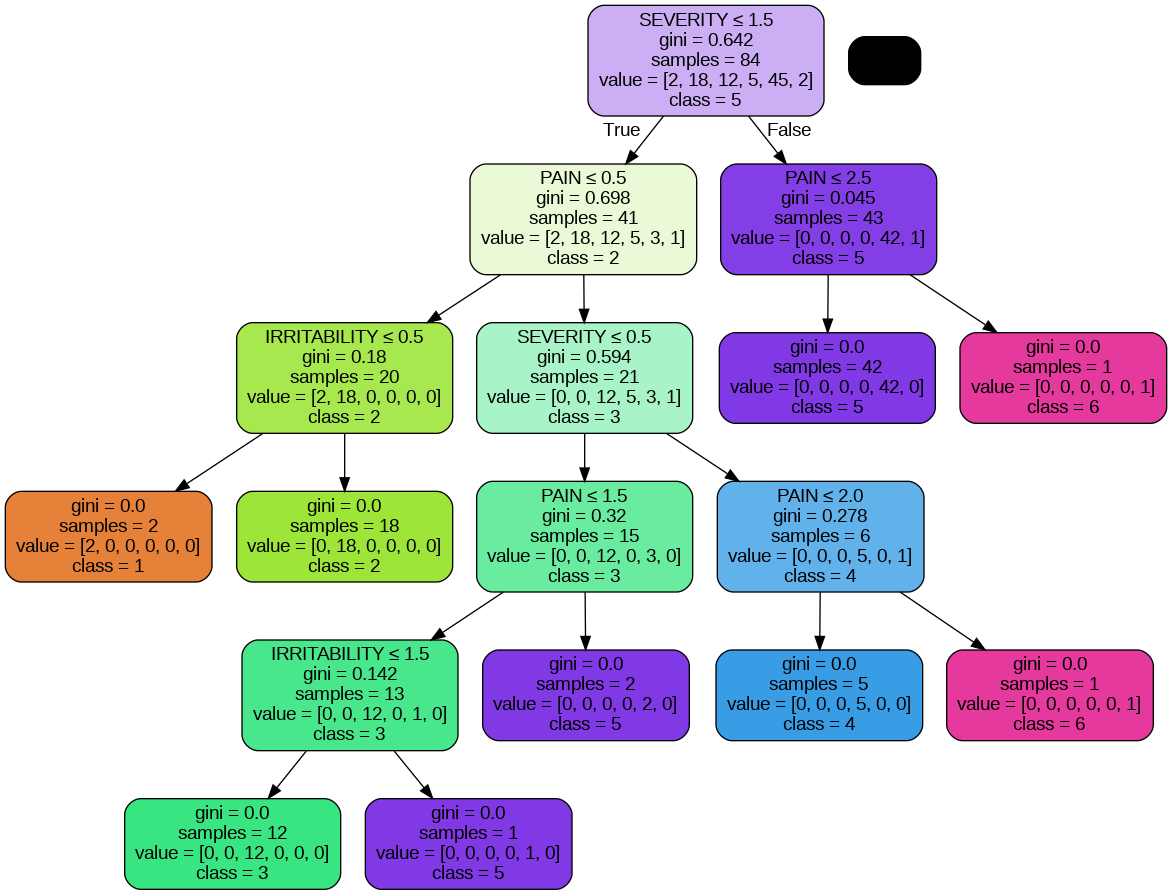

In [55]:
dot_data = StringIO()
export_graphviz(clf, 
                out_file=dot_data,  
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names=['PAIN', 'IRRITABILITY', 'SEVERITY'],
                class_names=['1', '2', '3', '4', '5', '6'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('DecisionTree.png')
Image(graph.create_png())